# Prepare the Data
## Importing python packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, IntegerType, DecimalType, StringType, BooleanType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Normalizer
from sklearn.linear_model import LinearRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import  NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Importing Data from csv

In [2]:
ROOT = r"C:\Users\Dell"
ROOTT = r"D:\spark\income_prediction"
DATA_IN = os.path.join(ROOT, "spark", "income_prediction")
DATA_OUT = os.path.join(ROOTT, "spark", "income_prediction")
SOURCE_DATASET = os.path.join(DATA_IN, "adult.csv")
SOURCE_ATTRIBUTES = os.path.join(DATA_IN, "metadata.csv")
COMBINED_DATA_OUT = f'{DATA_OUT}'

print("Source Dataset:", SOURCE_DATASET)
print("Source Attributes:", SOURCE_ATTRIBUTES)
print("COMBINED_DATA_OUT:", COMBINED_DATA_OUT)

Source Dataset: C:\Users\Dell\spark\income_prediction\adult.csv
Source Attributes: C:\Users\Dell\spark\income_prediction\metadata.csv
COMBINED_DATA_OUT: D:\spark\income_prediction\spark\income_prediction


### Instantiate Spark Session

In [3]:
spark=SparkSession \
    .builder \
    .appName("Income Predicton") \
    .getOrCreate()

## Create Schema
A file containing attributes was created. [data's decription](http://archive.ics.uci.edu/ml/datasets/Census+Income)

In [4]:
# Read attribute data from CSV file into a DataFrame
attrs = spark.read.csv(SOURCE_ATTRIBUTES, header=True)
# Display the contents of the DataFrame
attrs.show()

# Function to map attribute types to Spark data types
def get_field(t: str):
    if t == "continuous":
        return DecimalType()
    elif t == "string":
        return StringType()
    elif t == "boolean":
        return BooleanType()
    else:
        raise Exception("Not expected: %s" % t)
        
# Function to convert a row to a StructField
def to_struct(row) -> StructField:
    # Create a StructField with attribute description, inferred data type, and non-nullable
    return StructField(row['description'], get_field(row['type']), nullable=False)

# Apply the to_struct function to each row and collect StructFields
struct_fields = attrs.rdd.map(to_struct).collect()

# Construct a schema using the collected StructFields
schema=StructType(struct_fields)

+-----+----------+--------------+--------------------+-------+
| name|      type|   description|              values|    _c4|
+-----+----------+--------------+--------------------+-------+
|   A1|continuous|           age|                null|   null|
|   A2|    string|     workclass|Private, Self-emp...|   null|
|   A3|continuous|        fnlwgt|                null|   null|
|   A4|    string|     education|Bachelors, Some-c...|   null|
|   A5|continuous| education-num|                null|   null|
|   A6|    string|marital-status|Married-civ-spous...|   null|
|   A7|    string|    occupation|Tech-support, Cra...|   null|
|   A8|    string|  relationship|Wife, Own-child, ...|   null|
|   A9|    string|          race|White, Asian-Pac-...|   null|
|  A10|    string|           sex|        Female, Male|   null|
|  A11|continuous|  capital-gain|                null|   null|
|  A12|continuous|  capital-loss|                null|   null|
|  A13|continuous|hours-per-week|                null| 

## Load the Training Data
The function `load_data(file: str)` is combining the metadata schema and actual data.

In [5]:
def load_data(file: str):
    return spark.read.load(file, format="csv", sep=",", header=False, ignoreLeadingWhiteSpace=True,
                           ignoreTrailingWhiteSpace=True, schema=schema)

df = load_data(SOURCE_DATASET)
df.show(5)
df.printSchema()
df.count()


+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education-num|marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 90|        ?| 77053|     HS-grad|            9|       Widowed|                ?|Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|  Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial|Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|        ?|186061|Some-college|           10|       Widowed|                ?|    Unmarried|Black|Female|           0|        4356|

32561

# Clean Training Data
As it is, the training data is not ready for planned analysis:

## Convert Label Column
The goal of our categorization model is to make predictions about whether a person's annual income exceeds $50,000. Given that we have a limited number of categories, we can represent them using either a binary integer or a boolean type.

The function `convert_label_col(df: DataFrame)` will be created and used again later.

In [6]:
# Define a function to convert the label column in the DataFrame
 # Modify the 'income' column: replace '>50K' with 1, else replace with 0
def convert_label_col(df):
    df = df.withColumn('income', 
                      f.when(
                          (f.col('income') == '>50K') , 1)
                      .otherwise(0)
                     )
    # Convert the 'income' column to DecimalType for consistency
    return df.withColumn('income', df['income'].cast(DecimalType()))
    

df = convert_label_col(df)
df.select('income').distinct().show()


+------+
|income|
+------+
|     0|
|     1|
+------+



## Handle Missing Data
Missing values have been replaced with a '?' character. These values may make our model less accurate.



In [7]:
# Define a function to count rows with missing data in a DataFrame
def count_rows_with_missing_data(df: DataFrame):
    return df.select([f.sum(f.when(f.col(c) == '?', 1).otherwise(0)).alias(c) for c in df.columns])
    # For each column in the DataFrame, calculate the sum of 1s where the value is '?'
    # If the value is '?', it indicates missing data, so 1 is added; otherwise, 0 is added
 
    # This results in a DataFrame with counts of missing data for each column
count_rows_with_missing_data(df).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education-num|marital-status|occupation|relationship|race|sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|     1836|     0|        0|            0|             0|      1843|           0|   0|  0|           0|           0|             0|           583|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



## Remove unknown values
As previously discussed, we will remove the rows with unknown text values which cannot be imputed.

In [8]:
df_cleaned = df.replace('?', None)
# Drop rows with any null values
df_cleaned = df_cleaned.dropna()
df = df_cleaned

Removing the ? from data

In [9]:
def count_rows_with_missing_data(df: DataFrame):
    return df.select([f.sum(f.when(f.col(c) == '?', 1).otherwise(0)).alias(c) for c in df.columns])

count_rows_with_missing_data(df).show()
total_rows=df.count()
rows_with_missing_data=total_rows-(df_cleaned).count()
percentage=rows_with_missing_data*100/total_rows

print(percentage)

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education-num|marital-status|occupation|relationship|race|sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+

0.0


In [10]:
#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string')]
numericColumns = [item[0] for item in df.dtypes if item[1].startswith('decimal')]

print(f'Numeric: {numericColumns}')
print(f'Categorical: {categoricalColumns}')

count_rows_with_missing_data(df).select(numericColumns).show()

Numeric: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']
Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
+---+------+-------------+------------+------------+--------------+------+
|age|fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|income|
+---+------+-------------+------------+------------+--------------+------+
|  0|     0|            0|           0|           0|             0|     0|
+---+------+-------------+------------+------------+--------------+------+



## Combining dataset after data clean up

Filtering out all the missing values, we can see the impact this has on the dataset:

In [11]:
spark = SparkSession.builder.appName("DataCombinationApp").getOrCreate()

# Load the first CSV file into a DataFrame
def load_data(file: str):
    return spark.read.load(file, format="csv", sep=",", header=False, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, schema=schema)

df_combined = df

df_combined.toPandas().to_csv(r'D:\spark\income_prediction\combined_data.csv', sep=",",header=True, index=False)
# Perform further operations or analysis on the combined DataFrame if needed

df_combined.show()
df.printSchema()
df.describe()

+---+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|education-num|    marital-status|       occupation|  relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 82|         Private|132870|     HS-grad|            9|           Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States|     0|
| 54|         Private|140359|     7th-8th|            4|          Divorced|Machine-op-inspct|     Unmarried|White|Female|           0|        3900|            40| United-States|     0|
| 41|         Private|264663|Some-college|           10|         Separated|

DataFrame[summary: string, age: string, workclass: string, fnlwgt: string, education: string, education-num: string, marital-status: string, occupation: string, relationship: string, race: string, sex: string, capital-gain: string, capital-loss: string, hours-per-week: string, native-country: string, income: string]

Our model should improve without these entries, but it may be useful to keep them around for other kinds of analysis.
When training our model, we will export the data for additional examination and remove any null values.

# Data Characteristics
When representing the population, we must multiply any counts by fnlwgt to get the true proportion.

In [12]:
print('Sex:')
df_combined.groupby('sex').count().show(5)

print('Education:')
df_combined.groupby('education').count().show(5)

print('Education_num:')
df_combined.groupby('education-num').count().sort('education-num', ascending=False).show(5)


Sex:
+------+-----+
|   sex|count|
+------+-----+
|Female| 9782|
|  Male|20380|
+------+-----+

Education:
+----------+-----+
| education|count|
+----------+-----+
|      10th|  820|
|   Masters| 1627|
|   5th-6th|  288|
|Assoc-acdm| 1008|
| Assoc-voc| 1307|
+----------+-----+
only showing top 5 rows

Education_num:
+-------------+-----+
|education-num|count|
+-------------+-----+
|           16|  375|
|           15|  542|
|           14| 1627|
|           13| 5044|
|           12| 1008|
+-------------+-----+
only showing top 5 rows



countries insights in the data

In [13]:
distinct_countries_count=df.select(['native-country']).distinct().count()
print(f'Number of distinct countries: {distinct_countries_count}')
df_combined.groupby('native-country').count().show(distinct_countries_count)

Number of distinct countries: 41
+--------------------+-----+
|      native-country|count|
+--------------------+-----+
|         Philippines|  188|
|             Germany|  128|
|            Cambodia|   18|
|              France|   27|
|              Greece|   29|
|              Taiwan|   42|
|             Ecuador|   27|
|           Nicaragua|   33|
|                Hong|   19|
|                Peru|   30|
|               China|   68|
|               India|  100|
|  Holand-Netherlands|    1|
|               Italy|   68|
|                Cuba|   92|
|               South|   71|
|                Iran|   42|
|             Ireland|   24|
|                Laos|   17|
|            Thailand|   17|
|         El-Salvador|  100|
|              Mexico|  610|
|           Guatemala|   63|
|            Honduras|   12|
|          Yugoslavia|   16|
|         Puerto-Rico|  109|
|             Jamaica|   80|
|              Canada|  107|
|       United-States|27504|
|  Dominican-Republic|   67|
|Outlying-

# Preparing the Model
We'll train a Logistic Regression model for classification. To achieve this, we need to convert each row into a numerical vector.

## Irrelevant Data
The value listed under "fnlwgt" (Final Weight) is not related to the specific entry but instead represents the proportion of the overall population that the entry represents. We can disregard this value and proceed with our analysis.

As the term "education" is present in the indexed column "education-num," we can exclude it from consideration.

The function "remove_cols(df)" will be repeatedly utilized to cleanse our test data.

In [14]:
def remove_cols(df: DataFrame):
    df=df.drop('fnlwgt')
    return df.drop('education')

df_clean = remove_cols(df)

df_clean.show(5)


+---+---------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|education-num|marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 82|  Private|            9|       Widowed|  Exec-managerial|Not-in-family|White|Female|           0|        4356|            18| United-States|     0|
| 54|  Private|            4|      Divorced|Machine-op-inspct|    Unmarried|White|Female|           0|        3900|            40| United-States|     0|
| 41|  Private|           10|     Separated|   Prof-specialty|    Own-child|White|Female|           0|        3900|            40| United-States|     0|
| 34|  Private|            9|      Divorced|    Other-service|    Unmarried|White|

## Create String Indexer
Now we can convert all string values into numeric index values using a string indexer:

In [15]:
# Define your LABEL_COL based on your actual label column name
LABEL_COL = "income"

# List of categorical columns
categoricalColumns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed").fit(df) for column in categoricalColumns ]

pipeline = Pipeline(stages=indexers)

def index_strings(df: DataFrame):
    dfi = pipeline.fit(df).transform(df)
    return dfi.drop(*categoricalColumns).withColumn(LABEL_COL, df[LABEL_COL].cast(IntegerType()))

df_indexed = index_strings(df_clean)
df_indexed.show(5)


+---+-------------+------------+------------+--------------+------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
|age|education-num|capital-gain|capital-loss|hours-per-week|income|workclass_indexed|marital-status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native-country_indexed|
+---+-------------+------------+------------+--------------+------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
| 82|            9|           0|        4356|            18|     0|              0.0|                   4.0|               2.0|                 1.0|         0.0|        1.0|                   0.0|
| 54|            4|           0|        3900|            40|     0|              0.0|                   2.0|               6.0|                 3.0|         0.0|        1.0|                   0.0|
| 41|          

## Check for Redundant Features

Having indexed all the string values, we can establish a correlation matrix among the features. High correlations between features suggest redundancy, and we can eliminate one or more of these from our machine learning model.

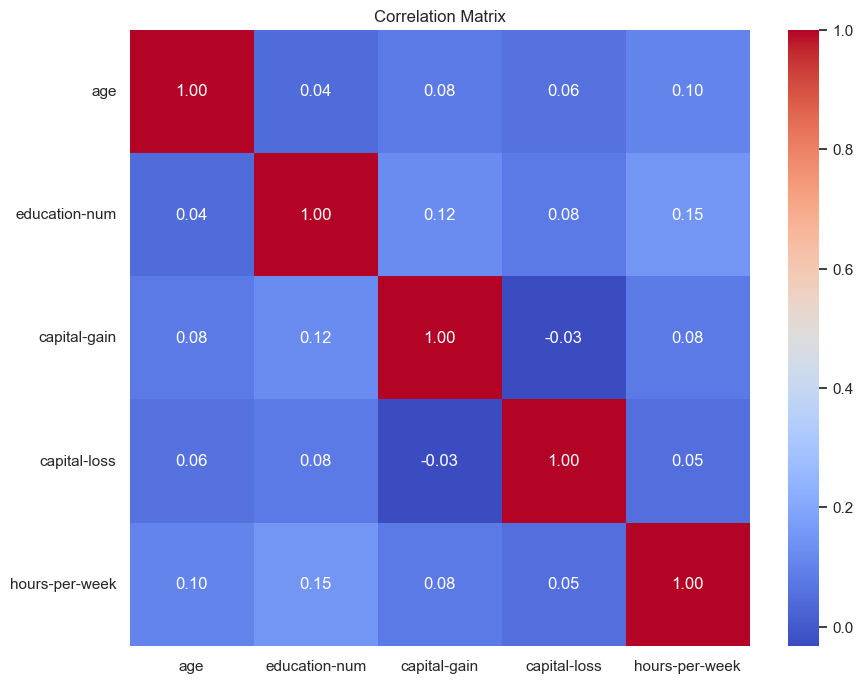

In [16]:
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Create a VectorAssembler to assemble features into a single vector column
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
assembled_df = assembler.transform(df_combined)

# Calculate the correlation matrix
matrix = Correlation.corr(assembled_df, "features").collect()[0][0]
correlation_matrix = matrix.toArray()

# Convert correlation matrix to a DataFrame
correlation_df = spark.createDataFrame(correlation_matrix.tolist(), numeric_features)

# Convert the DataFrame to Pandas for Seaborn plotting
correlation_pd = correlation_df.toPandas()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.set(style="white")

# Set y-axis labels as column names
ax = sns.heatmap(correlation_pd, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=numeric_features)

# Rotate y-axis labels for better readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Correlation Matrix")
plt.show()

## Create Feature Vectors

In [17]:
# Define the name of the vector column for assembling features
VECTOR_COL='features'

# Get the list of feature column names from the DataFrame
features=list(df_indexed.drop(LABEL_COL).toPandas().columns)

assembler=VectorAssembler(inputCols=features, outputCol=VECTOR_COL)

# Define a function to create a DataFrame with feature vectors
def create_feature_vector(df):
    df_vector = assembler.transform(df)
    return df_vector.select(*[VECTOR_COL, LABEL_COL])

# Call the create_feature_vector function on the indexed DataFrame
# This will create a DataFrame with feature vectors and the label column
df_vector = create_feature_vector(df_indexed)
df_vector.show(5)

+--------------------+------+
|            features|income|
+--------------------+------+
|[82.0,9.0,0.0,435...|     0|
|[54.0,4.0,0.0,390...|     0|
|[41.0,10.0,0.0,39...|     0|
|[34.0,9.0,0.0,377...|     0|
|[38.0,6.0,0.0,377...|     0|
+--------------------+------+
only showing top 5 rows



## Normalise Vectors

We to normalize the feature vectors using $L^1$ norm 

In [18]:
# Create a Normalizer instance to normalize the feature vectors
normalizer = Normalizer().setInputCol(VECTOR_COL).setOutputCol(f'{VECTOR_COL}_n').setP(1.0)

# Define a function to normalize the feature vectors in a DataFrame
# Transform the DataFrame using the Normalizer to normalize the feature vectors
# Drop the original feature vector column and rename the normalized one
def normalize_vector(df_vector):
    df_vector = normalizer.transform(df_vector)
    return df_vector.drop(VECTOR_COL).withColumnRenamed(f'{VECTOR_COL}_n',VECTOR_COL)

df_vector = normalize_vector(df_vector)
df_vector.show(5)


+------+--------------------+
|income|            features|
+------+--------------------+
|     0|[0.01833221551531...|
|     0|[0.01346633416458...|
|     0|[0.01025769326995...|
|     0|[0.00878780046523...|
|     0|[0.00983691431529...|
+------+--------------------+
only showing top 5 rows



In [19]:
# from pyspark.ml.classification import LogisticRegression

# training_data=df_vector

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01, featuresCol=VECTOR_COL, labelCol=LABEL_COL)
# Print out the parameters, documentation, and any default values.
print(f"LogisticRegression parameters:")
lr.explainParams()


LogisticRegression parameters:


"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: income)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimiza

# Classification

Logical Regression adapted from example in Spark documentation: https://spark.apache.org/docs/3.0.1/ml-pipeline.html

## Configure assembler for combined data

In [20]:
# Assemble all the features with VectorAssembler

numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")

final_df = assembler.transform(df_combined)
final_df.show(5)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+--------------------+
|age|workclass|fnlwgt|   education|education-num|marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|income|            features|
+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+--------------------+
| 82|  Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial|Not-in-family|White|Female|           0|        4356|            18| United-States|     0|[82.0,9.0,0.0,435...|
| 54|  Private|140359|     7th-8th|            4|      Divorced|Machine-op-inspct|    Unmarried|White|Female|           0|        3900|            40| United-States|     0|[54.0,4.0,0.0,390...|
| 41|  Private|264663|Some-col

## Spliting training and Preparing the Test Data
In a seperate file, additional values, with their classifications, is stored.

We will load this data and prepare it as we did our training data:

Train the model using the training data we prepared earlier

In [21]:
(training_set, test_set) = final_df.randomSplit([0.8,0.2], seed =2)
print("Training Dataset Count: " + str(training_set.count()))
print("Test Dataset Count: " + str(test_set.count()))

training_data=final_df

Training Dataset Count: 24220
Test Dataset Count: 5942


In [22]:
model1 = lr.fit(training_data)
print("Model 1 was fit using parameters: ")
model1.extractParamMap()

Model 1 was fit using parameters: 


{Param(parent='LogisticRegression_2a8c834b35e6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_2a8c834b35e6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_2a8c834b35e6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_2a8c834b35e6', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_2a8c834b35e6', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_2a8c834b35e6', name='labelCol', doc='label column name.'): 'income',
 Param(parent='LogisticRegression_2a8c834b35e6', name='maxBlockSizeInMB', doc='maximum memory in MB for 

## Model Training
Finally we can can put our model to the test.

In [23]:
# Random Forest Classification Model
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.classification import RandomForestClassifier

# Create a RandomForestClassifier instance
# This classifier will predict the 'income' label using the 'features' column
# numTrees specifies the number of decision trees in the random forest
randomforest = RandomForestClassifier(labelCol='income',featuresCol='features',numTrees=10)

# Fit the RandomForestClassifier on the training set
rcf_mod = randomforest.fit(training_set)

# Use the trained model to make predictions on the test set
rcf_pred = rcf_mod.transform(test_set)

# Create a MulticlassClassificationEvaluator instance to evaluate accuracy
MCE = MulticlassClassificationEvaluator(labelCol = 'income', metricName = 'accuracy')

# Calculate the accuracy of the Random Forest classifier's predictions
accuracy_rcf = MCE.evaluate(rcf_pred)

print('Accuracy of Random Forest Model:', accuracy_rcf)
print('Testing error of the Random Forest Model:' , (1.0 - accuracy_rcf))



Accuracy of Random Forest Model: 0.8187478963312016
Testing error of the Random Forest Model: 0.1812521036687984


In [24]:
# Decision Tree Classification Model

# from pyspark.ml.classification import DecisionTreeClassifier
dectree = DecisionTreeClassifier(labelCol='income',featuresCol='features',maxDepth=10)
dtc_mod = dectree.fit(training_set)
dt_pred = dtc_mod.transform(test_set)

accuracy_dt = MCE.evaluate(dt_pred)

print('Accuracy of Decision Tree Model:', accuracy_dt)
print('Testing error of the Decision Tree Model:' , (1.0 - accuracy_dt))

Accuracy of Decision Tree Model: 0.8167283742847526
Testing error of the Decision Tree Model: 0.18327162571524735


In [25]:
# Logistic Regression Classification Model

# from pyspark.ml.classification import LogisticRegression

logreg = LogisticRegression(labelCol='income',featuresCol='features',maxIter=10)
lrc_mod = logreg.fit(training_set)
lr_pred = lrc_mod.transform(test_set)

accuracy_lr = MCE.evaluate(lr_pred)

print('Accuracy of Logistic Regression Model:', accuracy_lr)
print('Testing error of the Logistic Regression Model:' , (1.0 - accuracy_lr))

Accuracy of Logistic Regression Model: 0.8093234601144396
Testing error of the Logistic Regression Model: 0.19067653988556044


In [26]:
# from pyspark.ml.classification import  NaiveBayes
# Create a NaiveBayesClassifier instance
nb = NaiveBayes( labelCol='income', featuresCol='features')

# Train the NaiveBayes model on the training data
nb_model = nb.fit(training_set)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_set)

# Evaluate the model's accuracy
nb_evaluator = MulticlassClassificationEvaluator(labelCol='income', metricName='accuracy')
accuracy_nb = nb_evaluator.evaluate(nb_predictions)

print('Accuracy of Naive Bayes Model:', accuracy_nb)
print('Testing error of the Naive Bayes Model:', 1.0 - accuracy_nb)

Accuracy of Naive Bayes Model: 0.7689330191854594
Testing error of the Naive Bayes Model: 0.23106698081454058


## Evaluate the Model

Finally, we can evaluate the success of our model with a classification evaluator:

In [27]:
# Accuracy summary of all three Machine Learning Models

# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator instance to evaluate model performance
# 'labelCol' specifies the column containing the true labels ('income' in this case)
# 'metricName' specifies the evaluation metric to use ('accuracy' in this case)
MCE = MulticlassClassificationEvaluator(labelCol = 'income', metricName = 'accuracy')

print('Accuracy of Random Forest Model:', MCE.evaluate(rcf_pred))
print('Accuracy of Decision Tree Model:', MCE.evaluate(dt_pred))
print('Accuracy of Logistic Regression Model:', MCE.evaluate(lr_pred))
print('Accuracy of NaiveBayes Model:', MCE.evaluate(nb_predictions))


Accuracy of Random Forest Model: 0.8187478963312016
Accuracy of Decision Tree Model: 0.8167283742847526
Accuracy of Logistic Regression Model: 0.8093234601144396
Accuracy of NaiveBayes Model: 0.7689330191854594


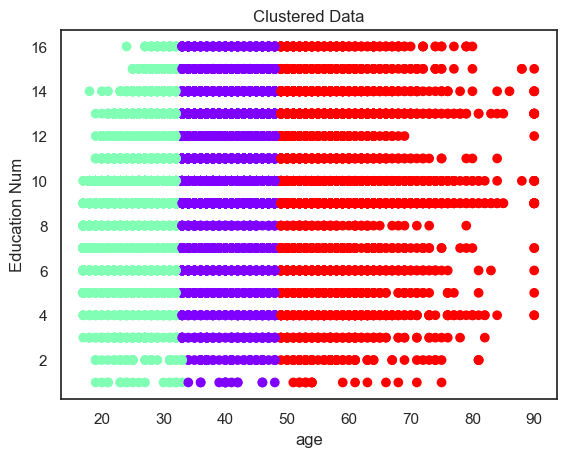

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

# Combine selected features into a feature vector
feature_columns = ['age', 'education-num']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_vector_df = assembler.transform(df)

# Create a KMeans model with k=3 clusters
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=10)

# Fit the KMeans model to the data
kmeans_model = kmeans.fit(feature_vector_df)

# Get the cluster centers
cluster_centers = kmeans_model.clusterCenters()

# Add cluster predictions to the DataFrame
clustered_df = kmeans_model.transform(feature_vector_df)

# Plot the clustered data
plt.scatter(clustered_df.toPandas()['age'], clustered_df.toPandas()['education-num'], c=clustered_df.toPandas()['cluster'], cmap='rainbow')
plt.xlabel('age')
plt.ylabel('Education Num')
plt.title('Clustered Data')
plt.show()


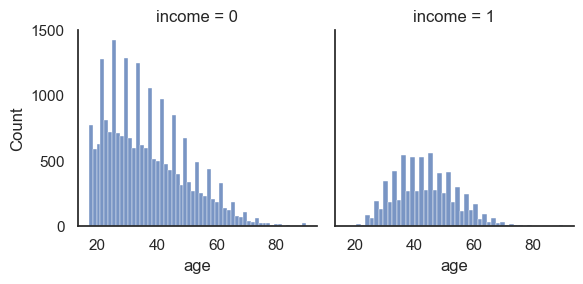

In [29]:
# Convert the PySpark DataFrame to a pandas DataFrame
df_pd = df_combined.toPandas()

# Explore Age vs Income
g = sns.FacetGrid(df_pd, col='income')
g = g.map(sns.histplot, "age")
# Show the plot
plt.show()

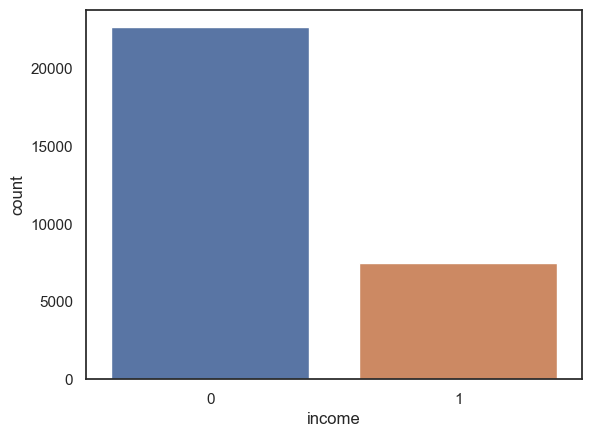

In [30]:
# Convert the PySpark DataFrame to a pandas DataFrame
df_pd = df_combined.toPandas()

sns.set(style='white', context='notebook', palette='deep')

# Create a count plot for the 'income' column
sns.countplot(x='income', data=df_pd, label="Count")

# Show the plot
plt.show()

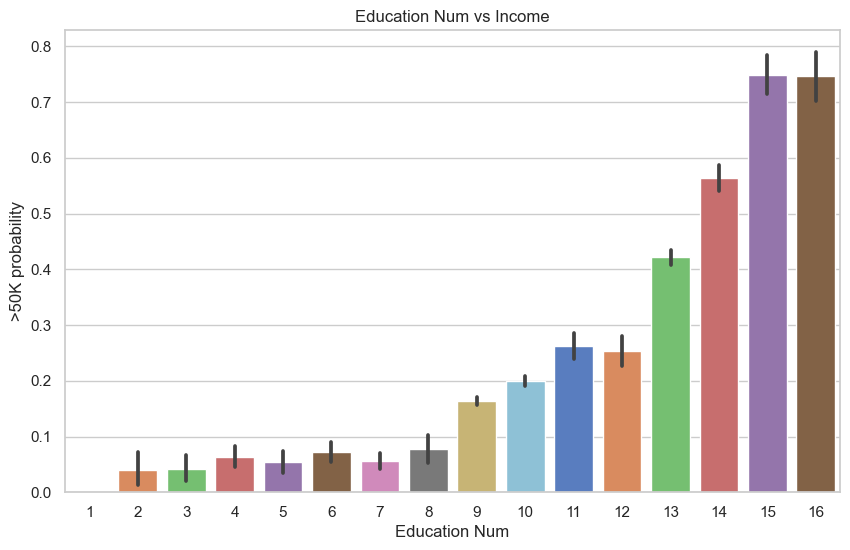

In [31]:
# import seaborn as sns
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_combined.toPandas()
df_pd['income'] = df_pd['income'].astype(float)

# Create a bar plot using Seaborn's barplot function
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x="education-num", y="income", data=df_pd, palette="muted")
plt.xlabel("Education Num")
plt.ylabel(">50K probability")
plt.title("Education Num vs Income")
plt.show()

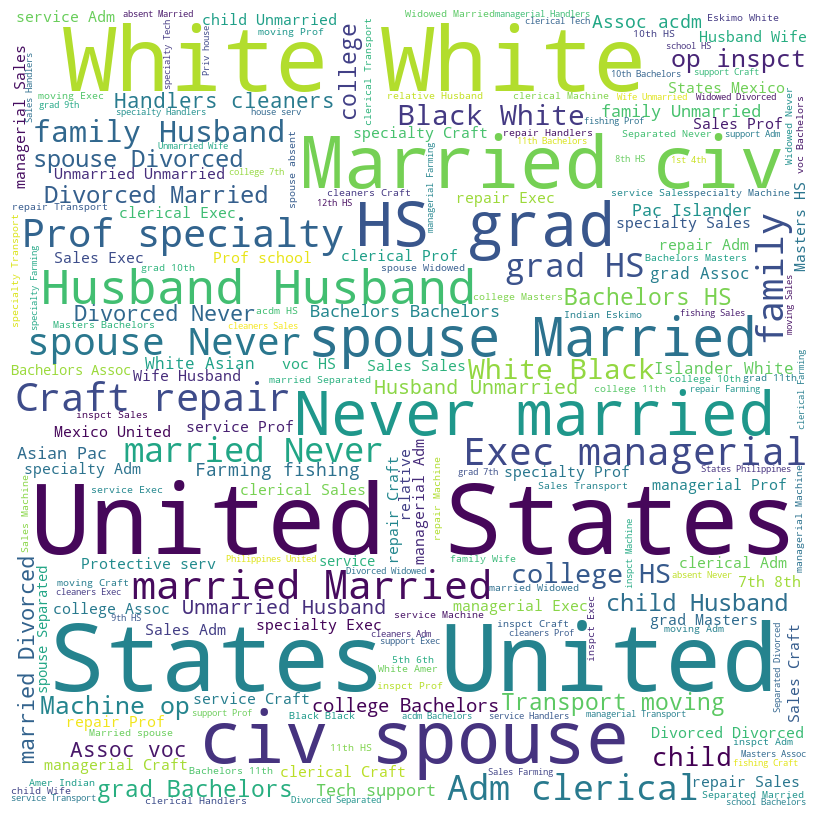

In [32]:
# from wordcloud import WordCloud

# Convert the Spark DataFrame to a Pandas DataFrame
df_pandas = df_combined.toPandas()

# List of columns that need to be treated as strings
# Convert specified columns to string type
integer_columns = ['education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
for col in integer_columns:
    df_pandas[col] = df_pandas[col].astype(str)
    
# Concatenate text from different columns into a single string    
text = ' '.join(df_pandas['education']) + ' ' + \
       ' '.join(df_pandas['marital-status']) + ' ' + \
       ' '.join(df_pandas['occupation']) + ' ' + \
       ' '.join(df_pandas['relationship']) + ' ' + \
       ' '.join(df_pandas['race']) + ' ' + \
       ' '.join(df_pandas['native-country'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

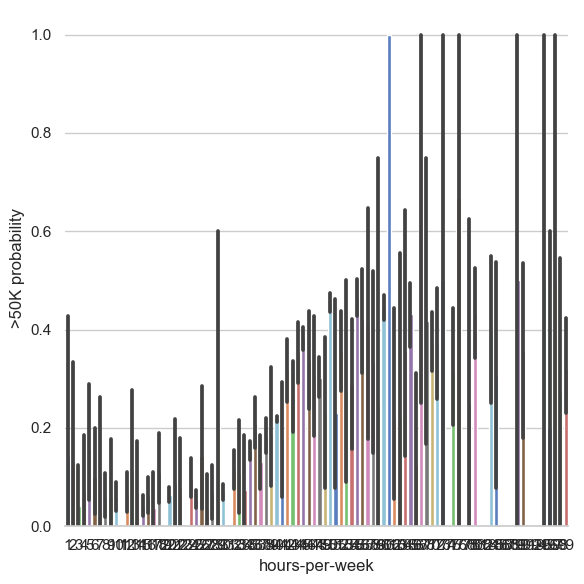

In [33]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_combined.toPandas()
df_pd['income'] = df_pd['income'].astype(float)
# Create a catplot using Seaborn's catplot function
g = sns.catplot(x="hours-per-week", y="income", data=df_pd, kind="bar", height=6, palette="muted")
g.despine(left=True)
g.set_ylabels(">50K probability")
plt.show()

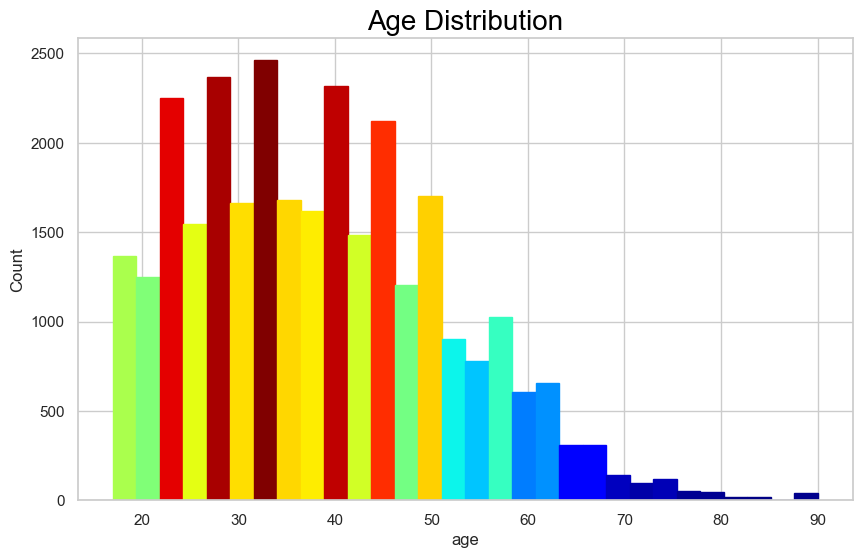

In [34]:
def hist(x, title):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(x, kde=False, bins=30)
    values = np.array([rec.get_height() for rec in ax.patches])
    norm = plt.Normalize(values.min(), values.max())
    colors = plt.cm.jet(norm(values))
    for rec, col in zip(ax.patches, colors):
        rec.set_color(col)
    plt.title(title, size=20, color='black')
    plt.show()

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_combined.toPandas()
hist(df_pd['age'], "Age Distribution")


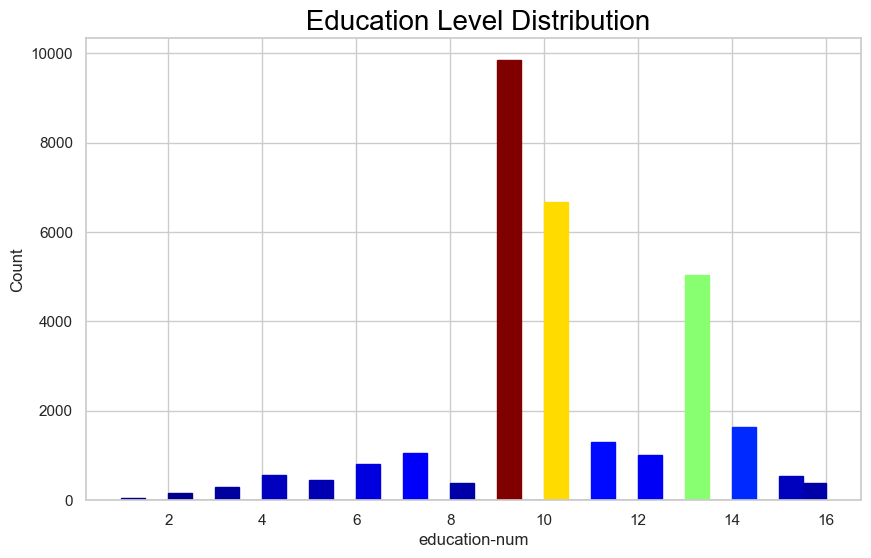

In [35]:
df_pd = df_combined.toPandas()
hist(df_pd["education-num"]," Education Level Distribution")

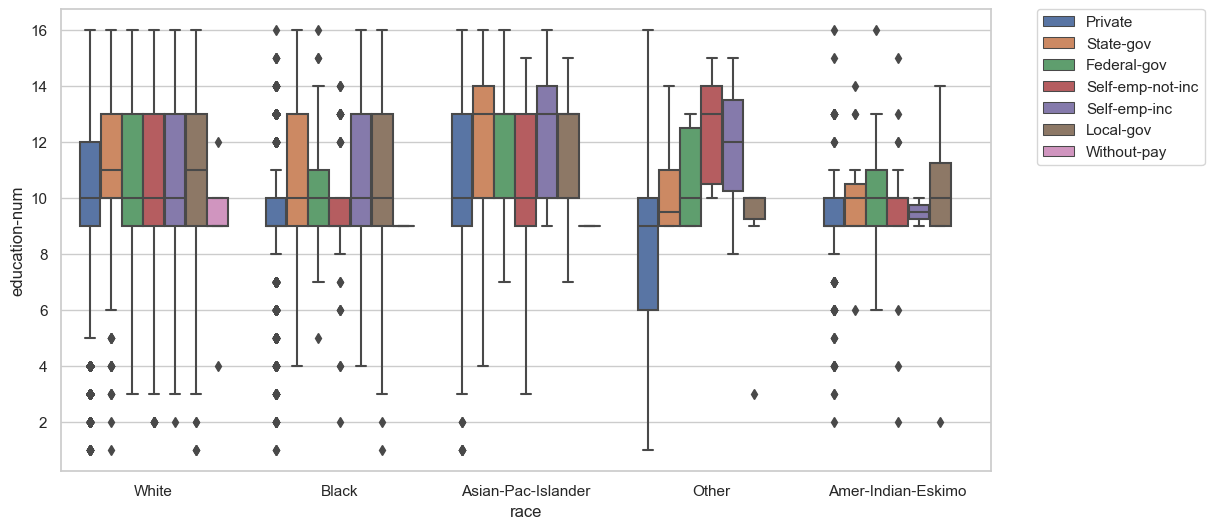

In [36]:
df_pd['education-num'] = df_pd['education-num'].astype(float)

# Check for missing or invalid values and handle them if necessary
df_pd.dropna(subset=['race', 'education-num', 'workclass'], inplace=True)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='education-num', data=df_pd, hue='workclass')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

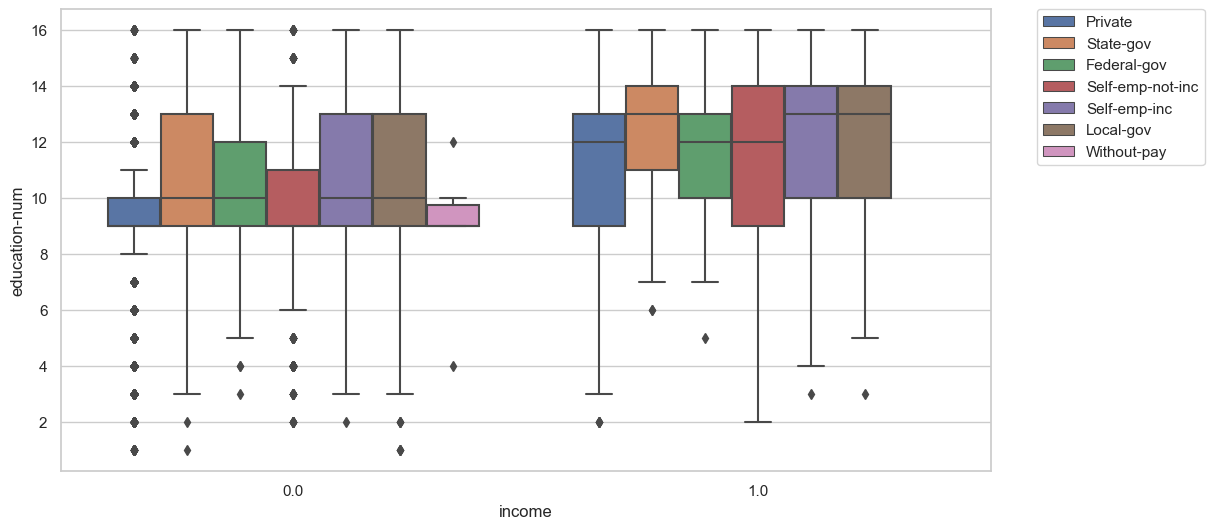

In [37]:
df_pd['education-num'] = df_pd['education-num'].astype(float)
df_pd['income'] = df_pd['income'].astype(float)

# Check for missing or invalid values and handle them if necessary
df_pd.dropna(subset=['income', 'education-num', 'workclass'], inplace=True)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='income', y='education-num', data=df_pd, hue='workclass')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

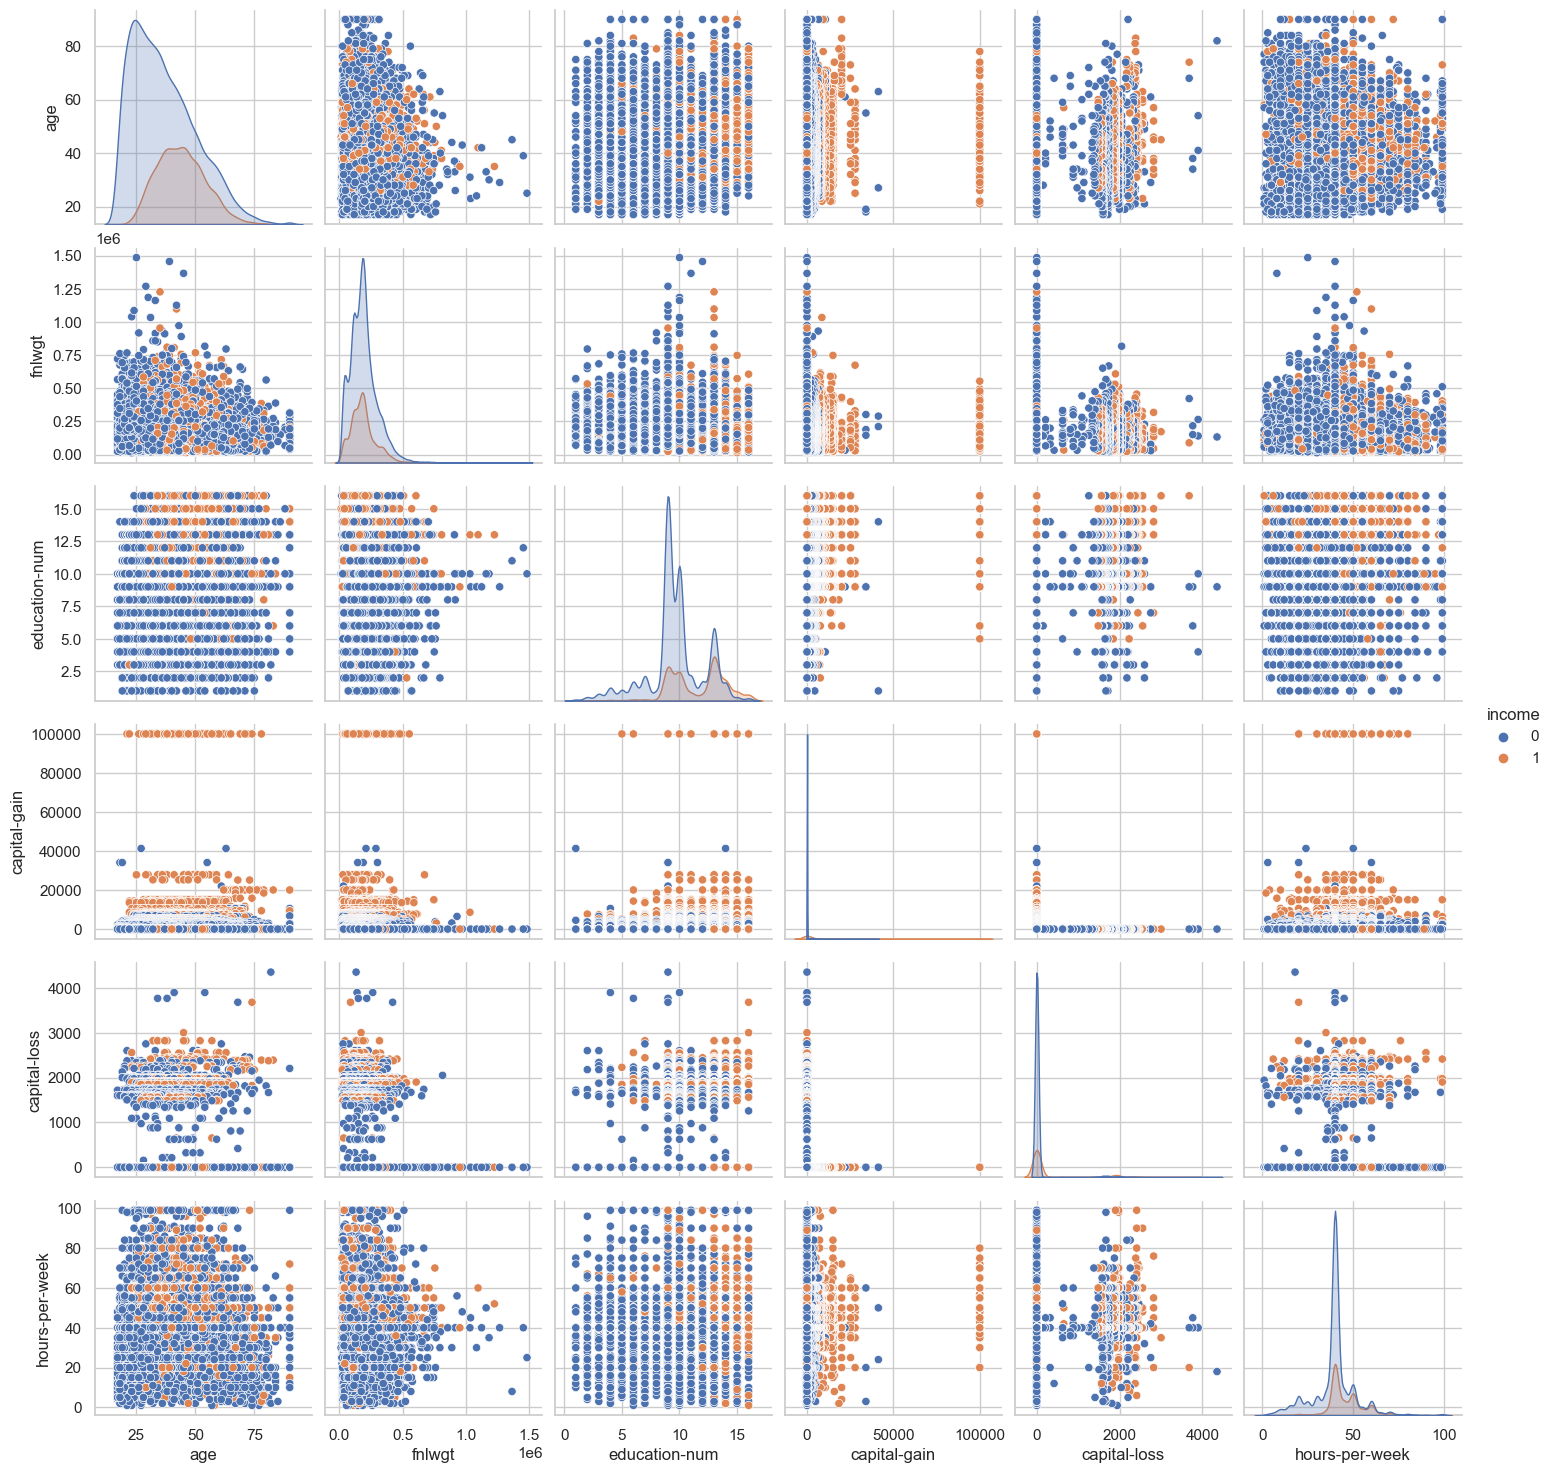

In [38]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_combined.toPandas()
# Create the pair plot using Seaborn
sns.pairplot(data=df_pd, hue='income')
# Reset any Pandas options you might have set
# pd.reset_option('mode.use_inf_as_null')


In [39]:
# Terminate the Spark application
spark.stop()

In [40]:

# from pyspark.ml.feature import VectorAssembler

# # Assuming you've already split your data into training_set and test_set

# # Create a VectorAssembler to transform feature columns into a single "features" column
# feature_column = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# assemblerr = VectorAssembler(inputCols=feature_column, outputCol="fts")


# # Transform the training set using the assembler
# training_data = assemblerr.transform(training_set)

# # Select the "features" and "income" columns for training
# x_train = training_data.select('fts')
# y_train = training_data.select('income')

# # Transform the test set using the assembler
# test_data = assembler.transform(test_set)

# # Select the "features" and "income" columns for testing
# x_test = test_data.select('fts')
# y_test = test_data.select('income')